In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import os, sys, shutil, time, os.path as osp, logging, numpy as np, imp
import torch
import matplotlib.pyplot as plt, cycler
import matplotlib
import mplhep as hep
from tqdm.notebook import tqdm
plt.style.use(hep.style.CMS)

HGCAL_LDRD_PATH = '../src' # Assuming cwd = hgcal_ldrd/notebooks
OUTPUT_PATH = osp.join(HGCAL_LDRD_PATH, '../output')
sys.path.append(HGCAL_LDRD_PATH)

In [2]:
sys.path.append(osp.join(HGCAL_LDRD_PATH, '../scripts'))

import edgenetscript
imp.reload(edgenetscript)

script = edgenetscript.TrainingScript(debug=False)
script.load_checkpoint = osp.join(
    HGCAL_LDRD_PATH, '../saved_weights',
    'models/model_checkpoint_EdgeNetWithCategories_264403_5b5c05404f_csharma.best.pth.tar'
    )
trainer = script.get_trainer()

    INFO:2020-07-23 02:30:00:edgenetscript:95 Using dataset_path /home/klijnsma/basehgcal/edgenetwithcats/hgcal_ldrd/scripts/../data/single-tau
    INFO:2020-07-23 02:30:00:edgenetscript:110 10000, [ 8000  8000 10000]
    INFO:2020-07-23 02:30:01:edgenetscript:152 using device cuda
    INFO:2020-07-23 02:30:05:base:31 Model: 
EdgeNetWithCategories(
  (inputnet): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
  )
  (edgenetwork): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=4, bias=True)
    (5): LogSoftmax()
  )
  (nodenetwork0): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=101, bias=Tru

In [3]:
from torch_geometric.data import DataLoader
full_dataset, train_dataset, valid_dataset = script.get_full_dataset()
# Use just a few events for testing
# valid_dataset = torch.utils.data.Subset(valid_dataset, list(range(3)))
valid_loader = DataLoader(valid_dataset, batch_size=script.valid_batch_size, shuffle=False)

In [4]:
class Event():
    @staticmethod
    def edge_predictions_to_node_predictions(
            predictions_edges,
            edge_index,
            num_classes,
            num_nodes,
            ):
        # Assume noise, and overwrite with the other classes
        predictions_nodes = np.zeros(num_nodes)
        for i_cat in range(1,num_classes):
            # Any node in this should belong to the category
            # This will be 2-dim, in and out
            nodes = edge_index[:, predictions_edges == i_cat]
            # Just get all the unique nodes in here
            unique_nodes_this_cat = np.unique(nodes)
            predictions_nodes[unique_nodes_this_cat] = i_cat
        return predictions_nodes
    
    @classmethod
    def from_batch(cls, data, batch_output):
        flatten = lambda torch_object: torch_object.cpu().numpy() if data.x.is_cuda else torch_object.numpy()
        
        probabilities_edges = batch_output.cpu().numpy()
        predictions_edges = np.argmax(probabilities_edges, axis=1)
        
        instance = cls(
            X = flatten(data.x),
            edge_index = flatten(data.edge_index),
            target_nodes = flatten(data.y_nodes),
            target_edges = flatten(data.y),
            predictions_edges = predictions_edges,
            probabilities_edges = probabilities_edges,
            )

        instance.predictions_nodes = cls.edge_predictions_to_node_predictions(
            instance.predictions_edges, instance.edge_index, instance.num_classes, instance.num_nodes
            )
        return instance
    
    def __init__(self, *args, **kwargs):
        self.__dict__.update(kwargs)
        self.num_classes = self.probabilities_edges.shape[1]
        self.num_nodes = self.X.shape[0]
        self.num_edges = self.edge_index.shape[0]

        
class EventFactory():
    def __init__(self, loader, max_events=None):
        self.loader = loader
        self.max_events = max_events
        self.do_tqdm = True
        
    def __iter__(self):
        with torch.no_grad():
            if self.do_tqdm:
                total = len(self.loader.dataset)
                if not(self.max_events is None) and self.max_events < total:
                    total = self.max_events
                iterator = tqdm(enumerate(self.loader), total=total)
            else:
                iterator = enumerate(self.loader)
            
            for i, data in iterator:
                if not(self.max_events is None) and i >= self.max_events: break
                batch_input = data.to(trainer.device)
                batch_target = data.y_nodes.type(torch.LongTensor).to(trainer.device)
                batch_output = trainer.model(batch_input)
                yield Event.from_batch(data, batch_output)      
                
for event in EventFactory(valid_loader):
    print(event)
    break

In [55]:
class PlotEventDisplay():
    cats = ['Noise', 'HAD', 'EM', 'MIP']
    catcolors = {
        'Noise' : 'xkcd:light blue',
        'HAD'   : 'xkcd:green',
        'EM'    : 'xkcd:red',
        'MIP'   : 'xkcd:yellow'
        }
    
    @classmethod
    def catcolor(cls, cat):
        if isinstance(cat, int): cat = cls.cats[cat]
        return cls.catcolors[cat]
    
    def __init__(self, event):
        self.event = event

    def plot_output(self, output, title=None, savefig=None):
        fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))        
        fig.set_facecolor('white')
        if title: fig.suptitle(title, fontsize=28)
        
        e_max = np.max(self.event.X[:,4])
        e_normed = 100.*np.tanh(self.event.X[:,4]/e_max)
                
        for i_cat in range(self.event.num_classes):
            color = self.catcolor(i_cat)
            X = self.event.X[output == i_cat]
            ax0.scatter(X[:,0], X[:,2], s=(e_normed), c=color)
            ax1.scatter(X[:,1], X[:,2], s=(e_normed), c=color)

        ax0.legend(['Noise', 'HAD', 'EM', 'MIP'], prop={'size': 24})
        fontsize = 24
        ax0.set_xlabel('x [cm]', fontsize=fontsize)
        ax0.set_ylabel('layer', fontsize=fontsize)
        ax1.set_xlabel('y [cm]', fontsize=fontsize)
        ax1.set_ylabel('layer', fontsize=fontsize)
        ax0.tick_params(axis='both', which='major', labelsize=20)
        ax1.tick_params(axis='both', which='major', labelsize=20)
        if savefig:
            fig.savefig(savefig)
            plt.close(fig)

    def plot_prediction(self, savefig=None):
        return self.plot_output(self.event.predictions_nodes, 'Prediction', savefig)
    
    def plot_truth(self, savefig=None):
        return self.plot_output(self.event.target_nodes, 'Truth', savefig)

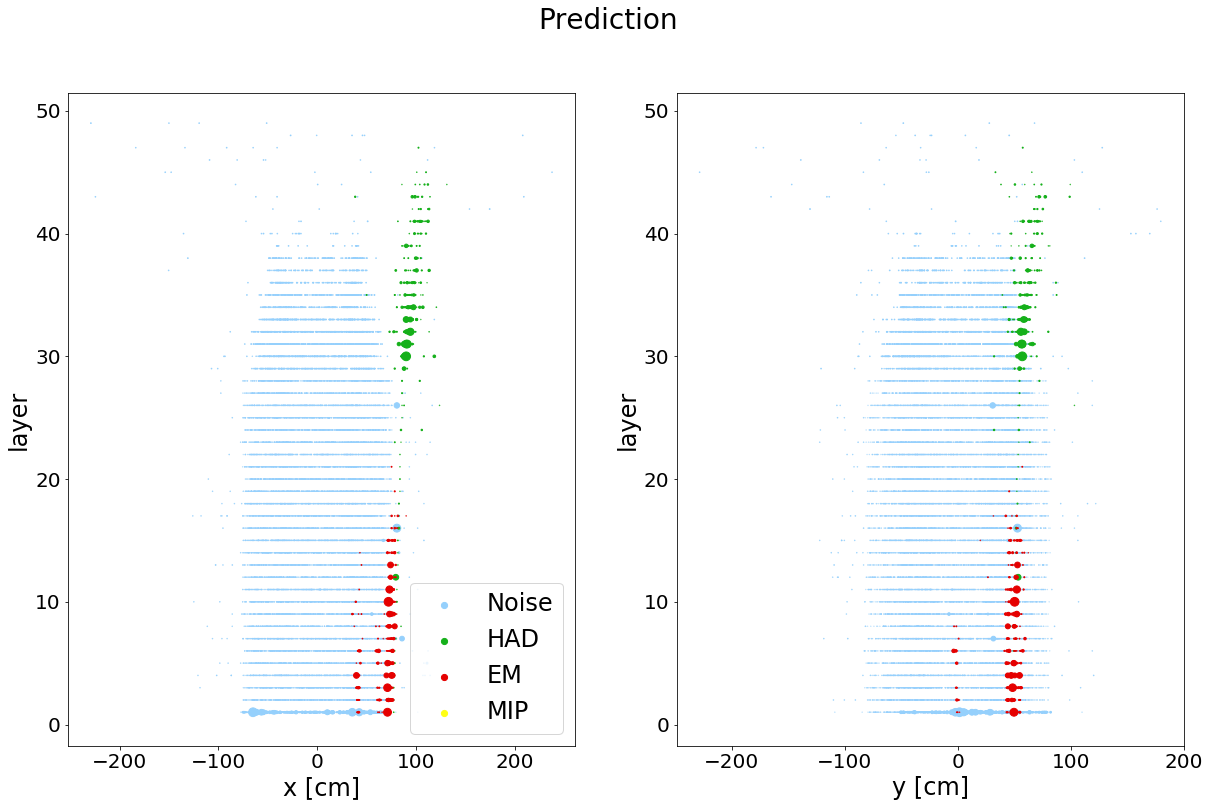

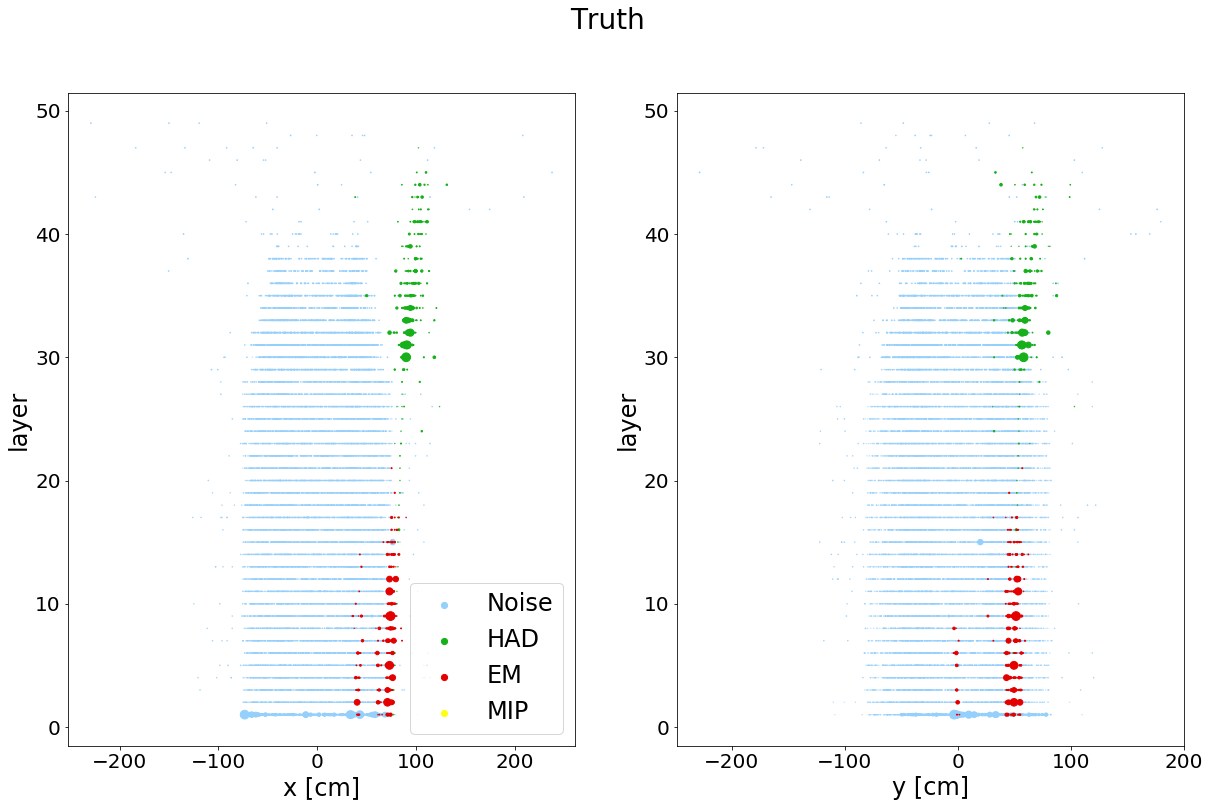

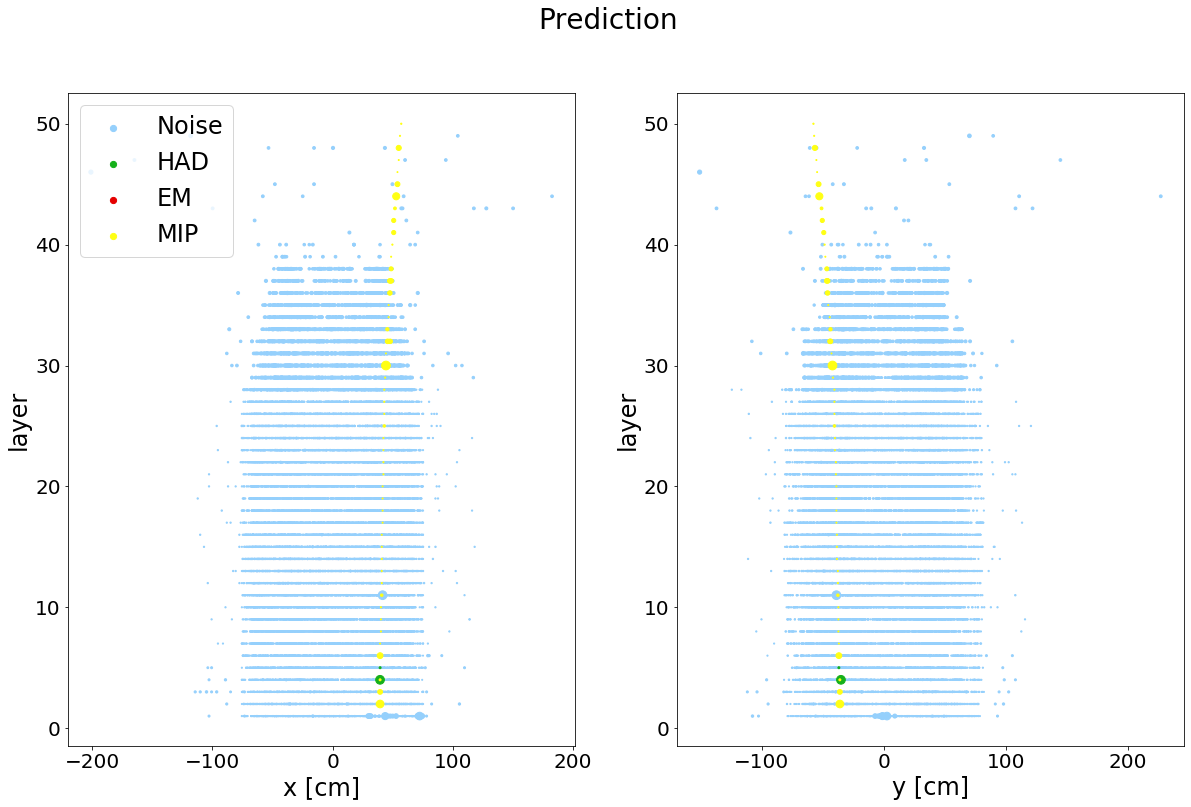

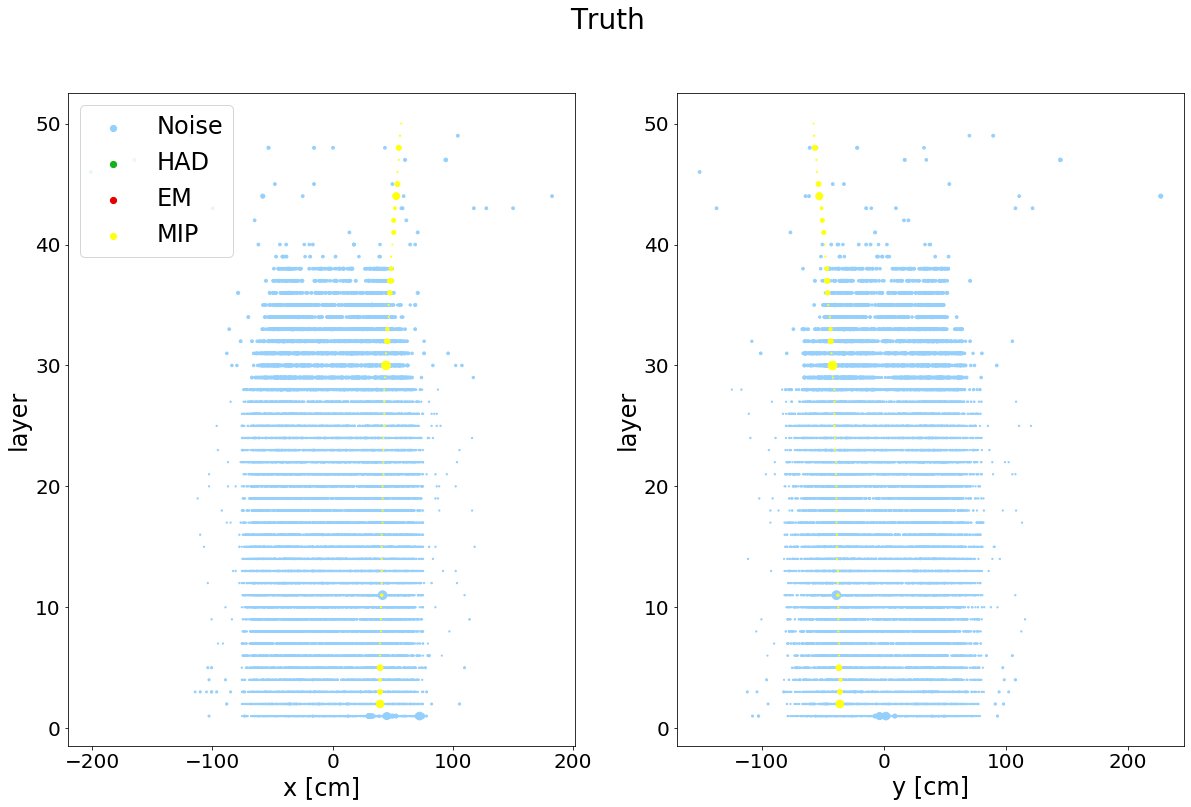

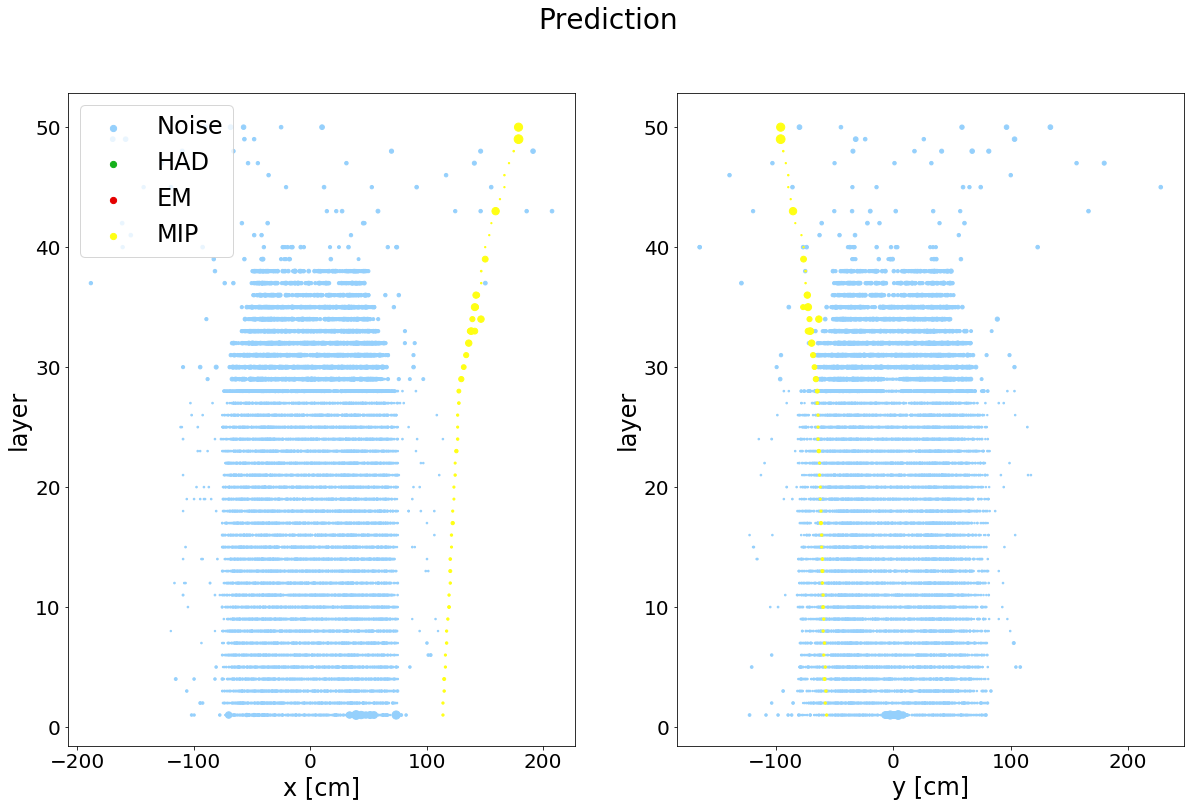

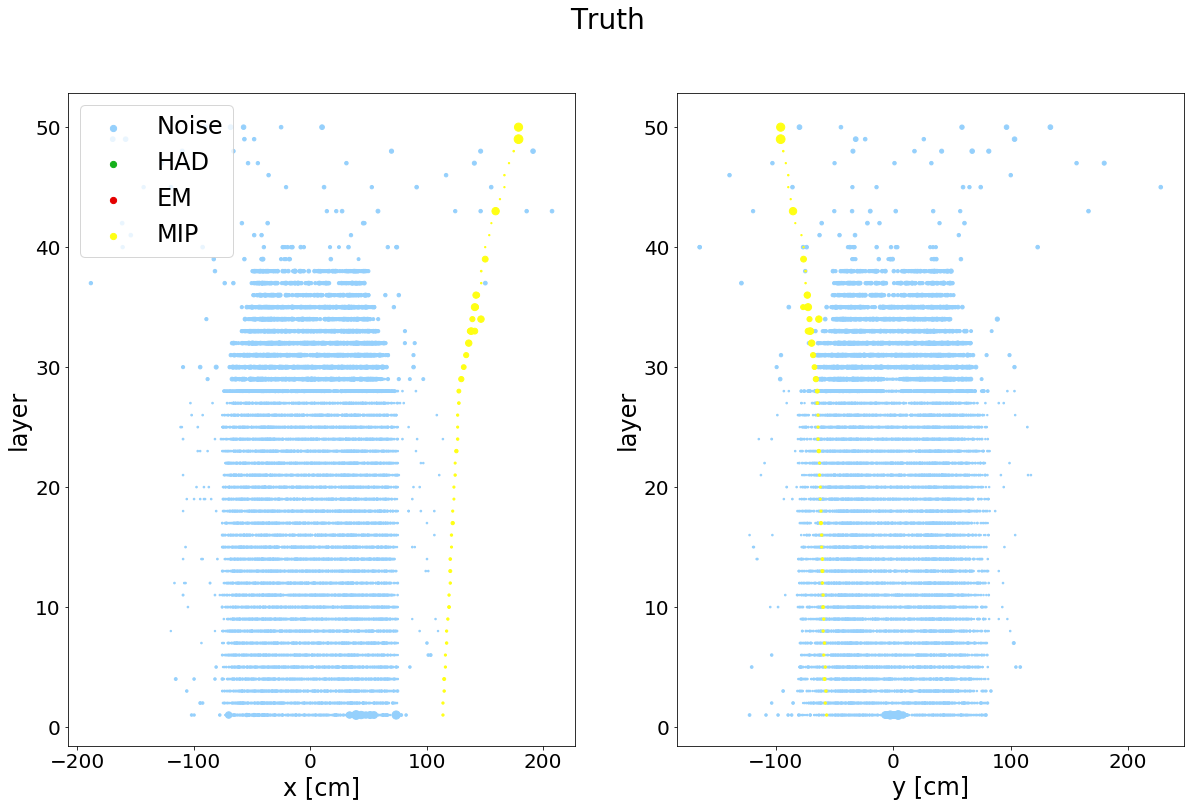

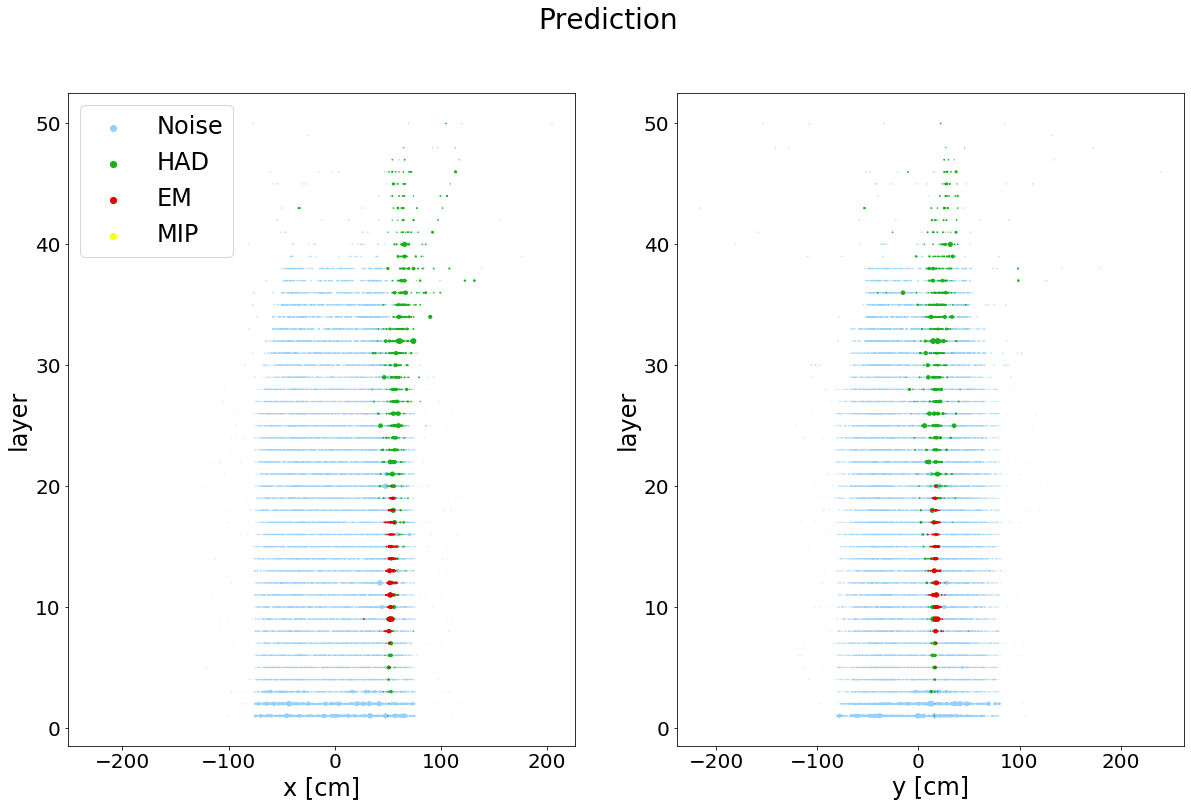

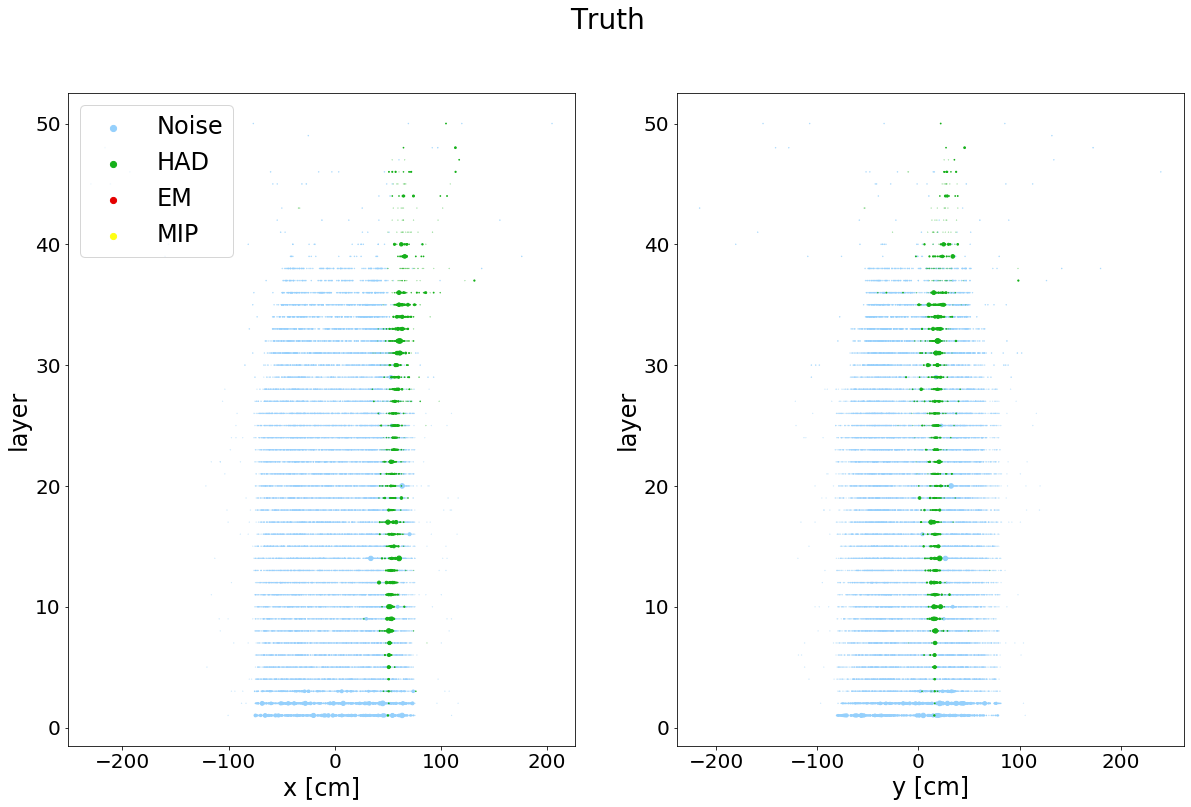

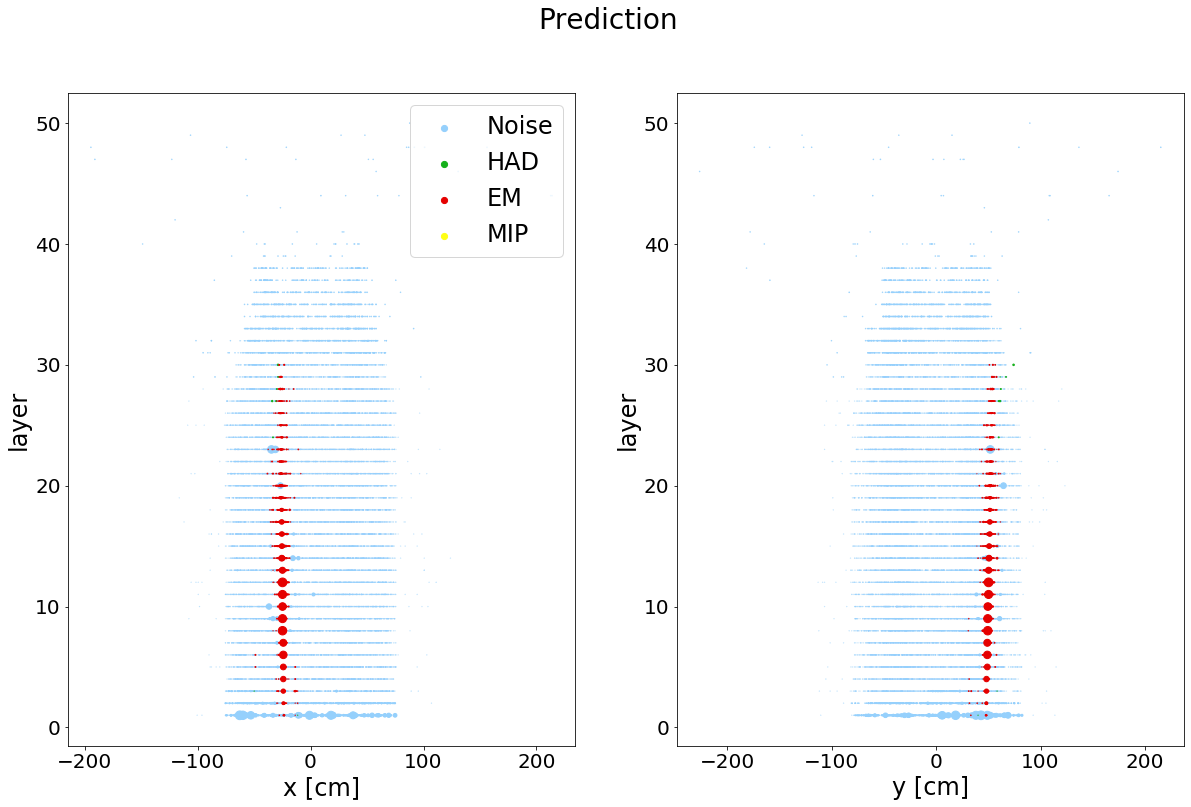

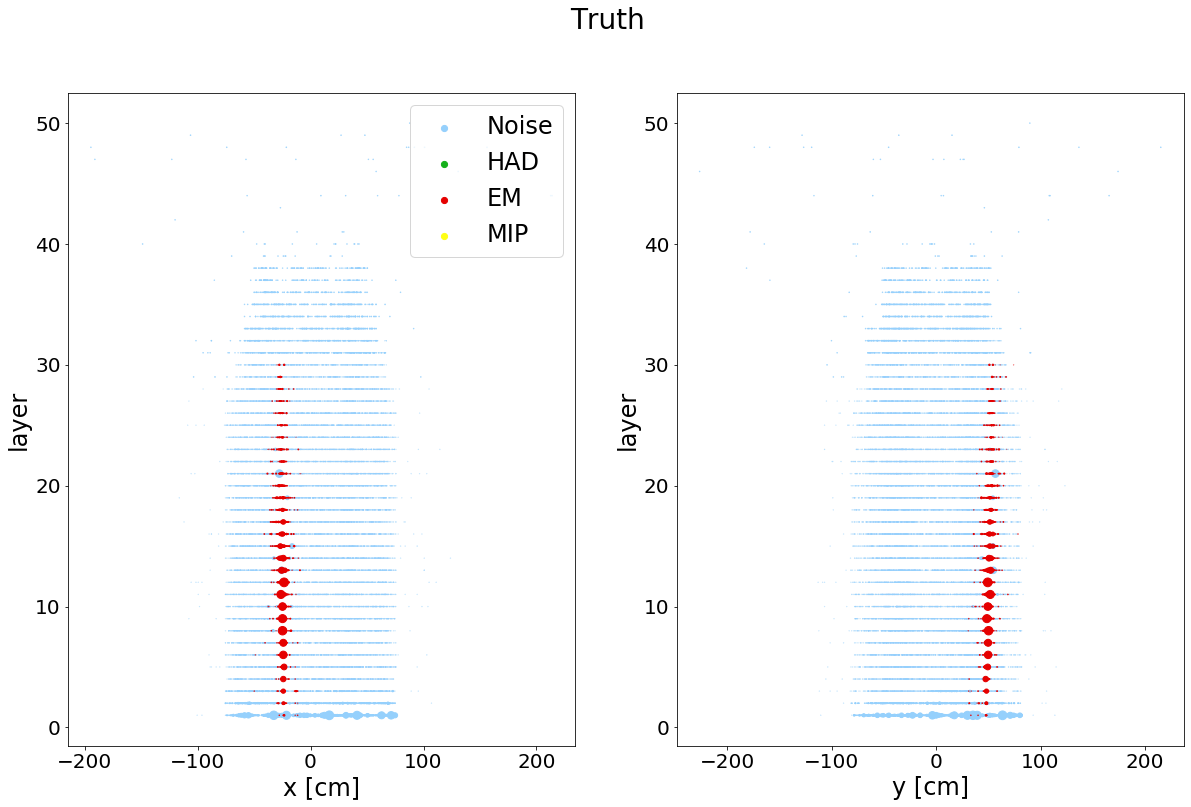

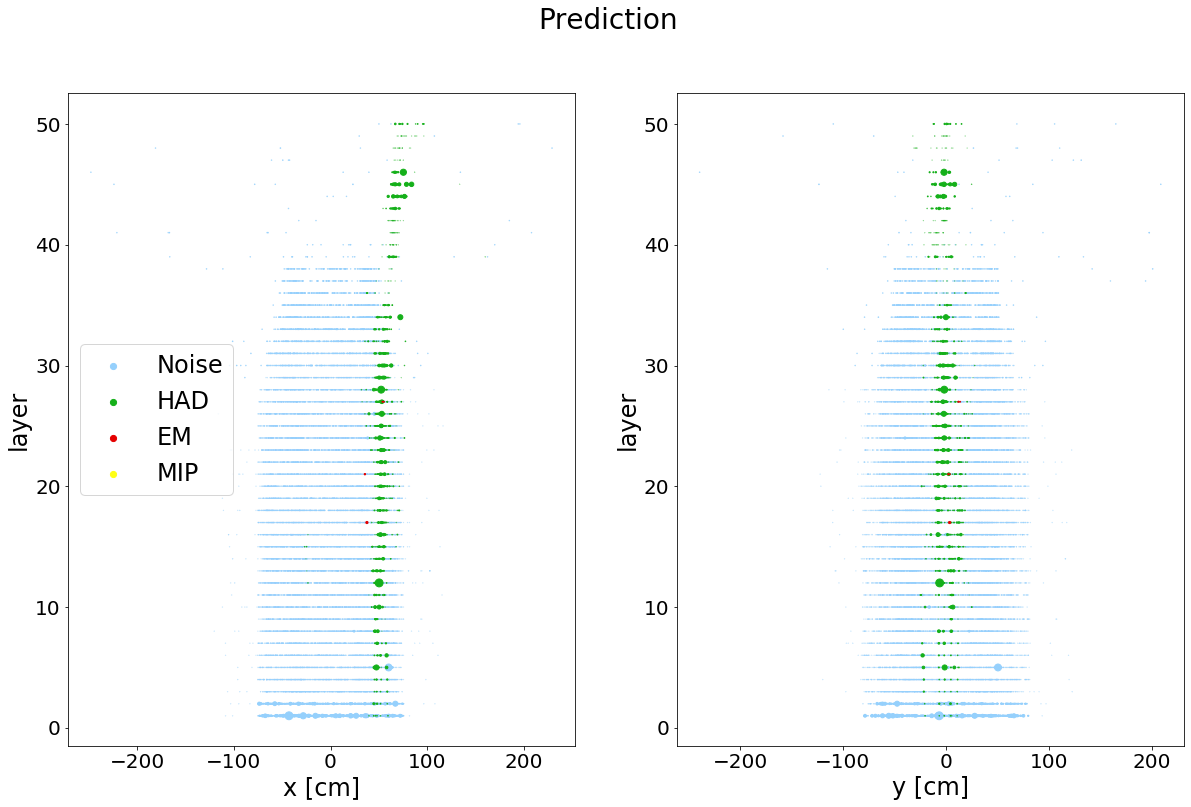

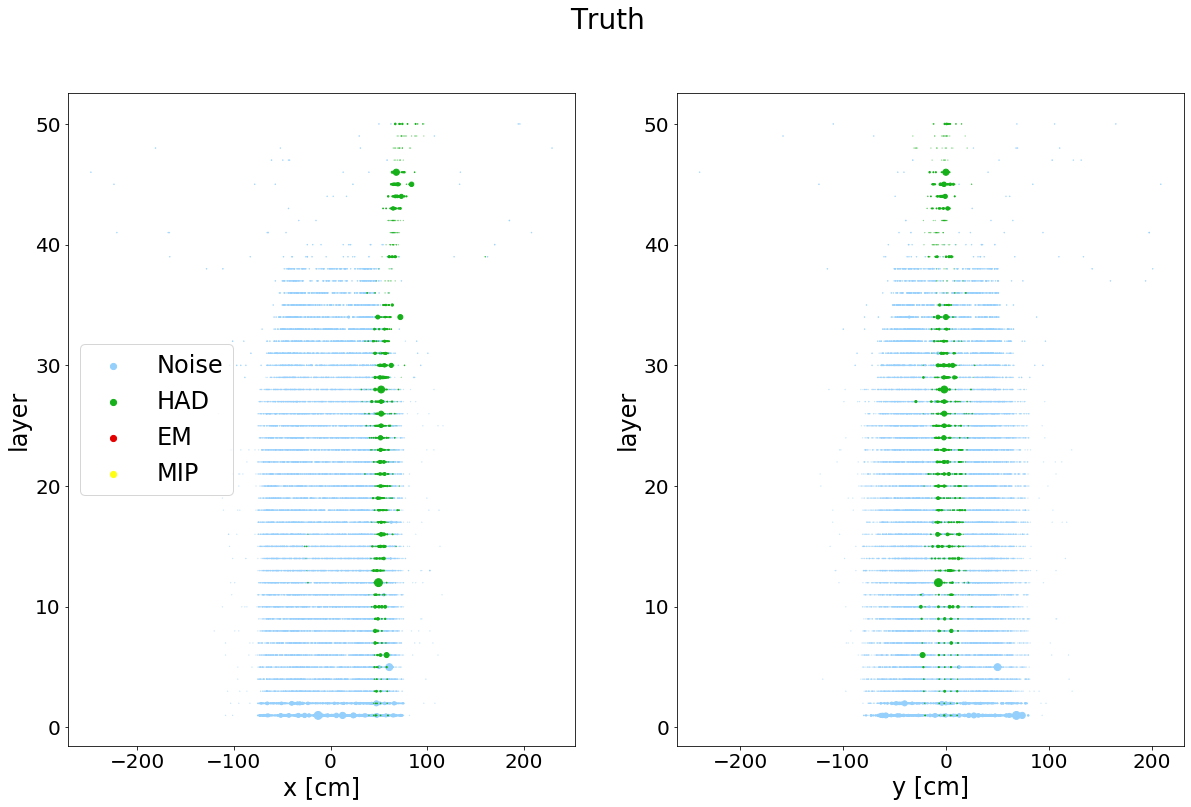

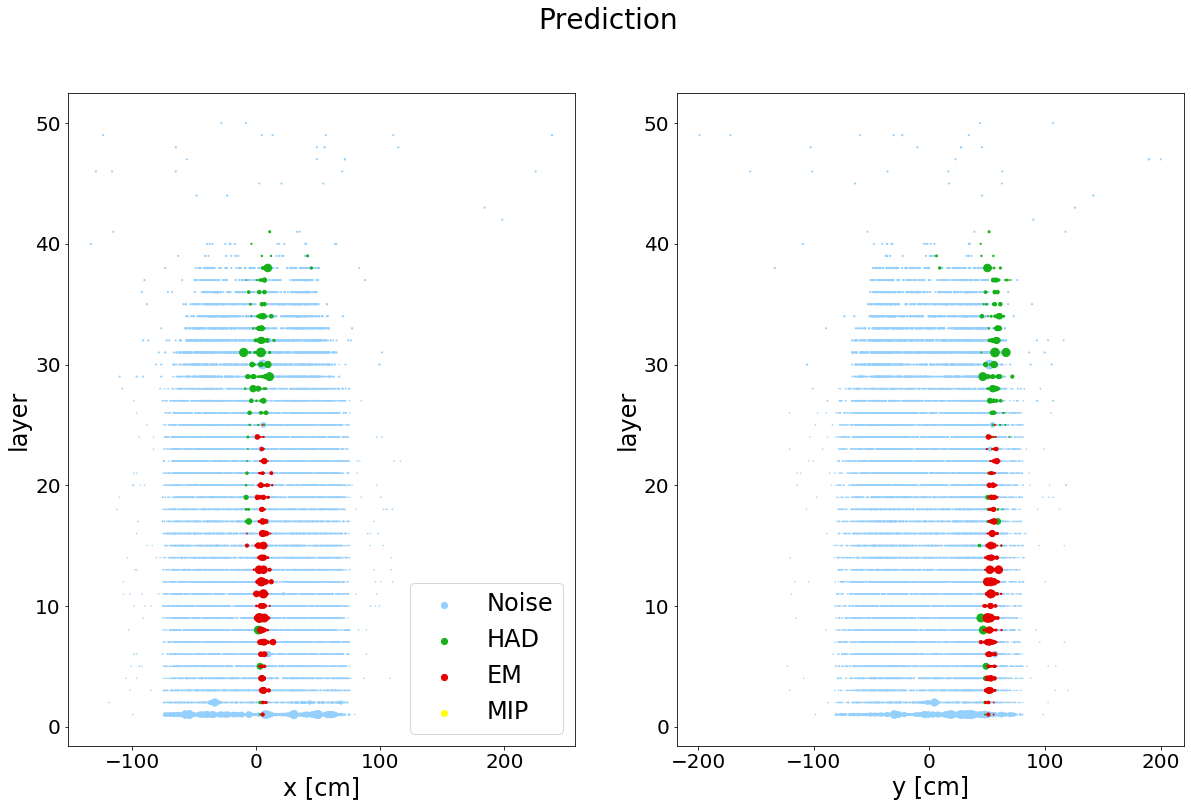

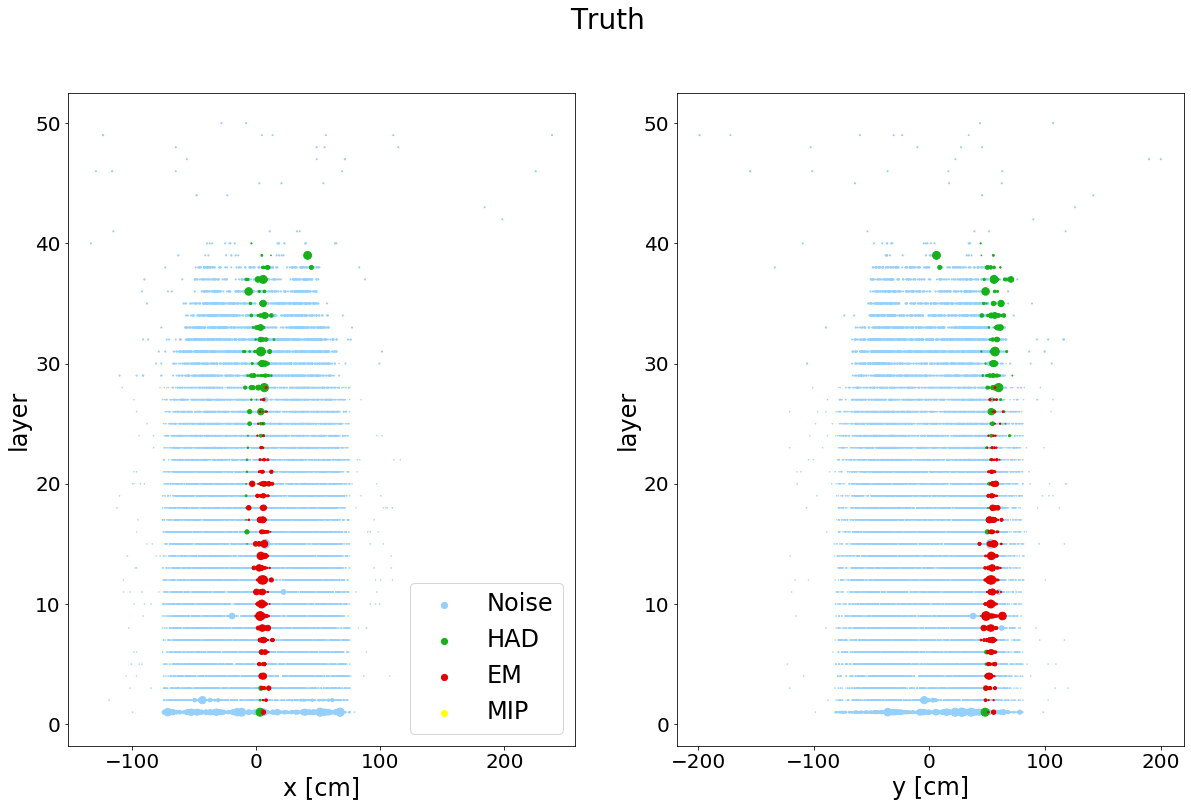

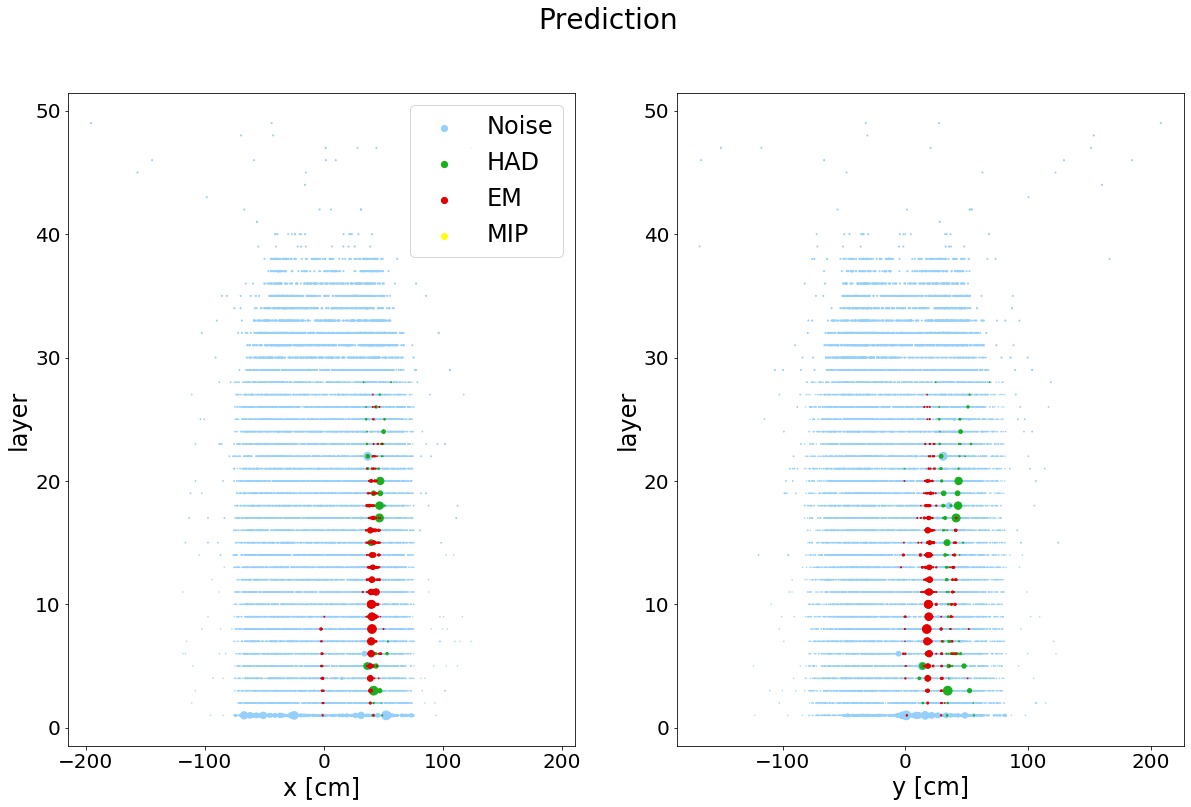

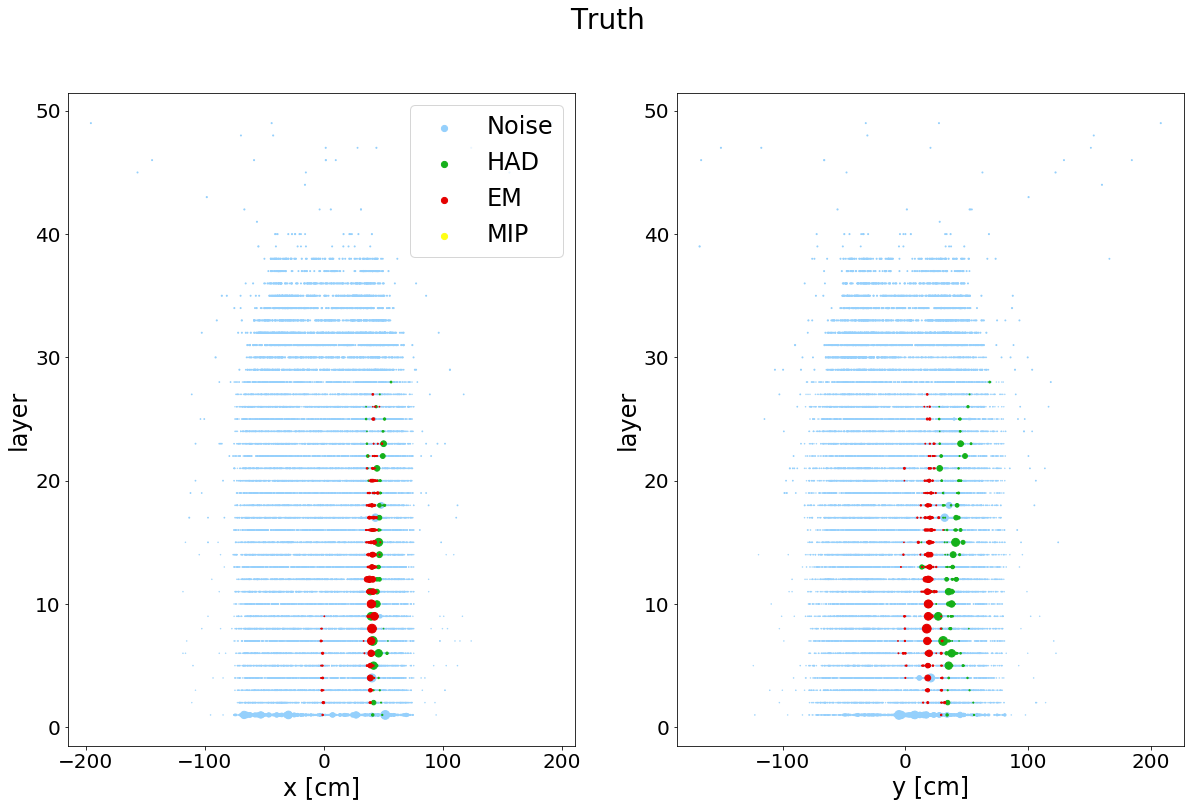

In [56]:
i = 0

for event in EventFactory(valid_loader):
    plot = PlotEventDisplay(event)
    plot.plot_prediction()
    plot.plot_truth()
    
    i += 1
    if i == 8: break

In [ ]:
if not osp.isdir('eventdisplays'): os.makedirs('eventdisplays')

backend_ =  matplotlib.get_backend() 
matplotlib.use("Agg")  # Prevent showing stuff

for i_event, event in enumerate(EventFactory(valid_loader, max_events=100)):
    plot = PlotEventDisplay(event)
    plot.plot_prediction('eventdisplays/{0:03d}_pred.png'.format(i_event))
    plot.plot_truth('eventdisplays/{0:03d}_truth.png'.format(i_event))

matplotlib.use(backend_) # Reset backend

# Statistics

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


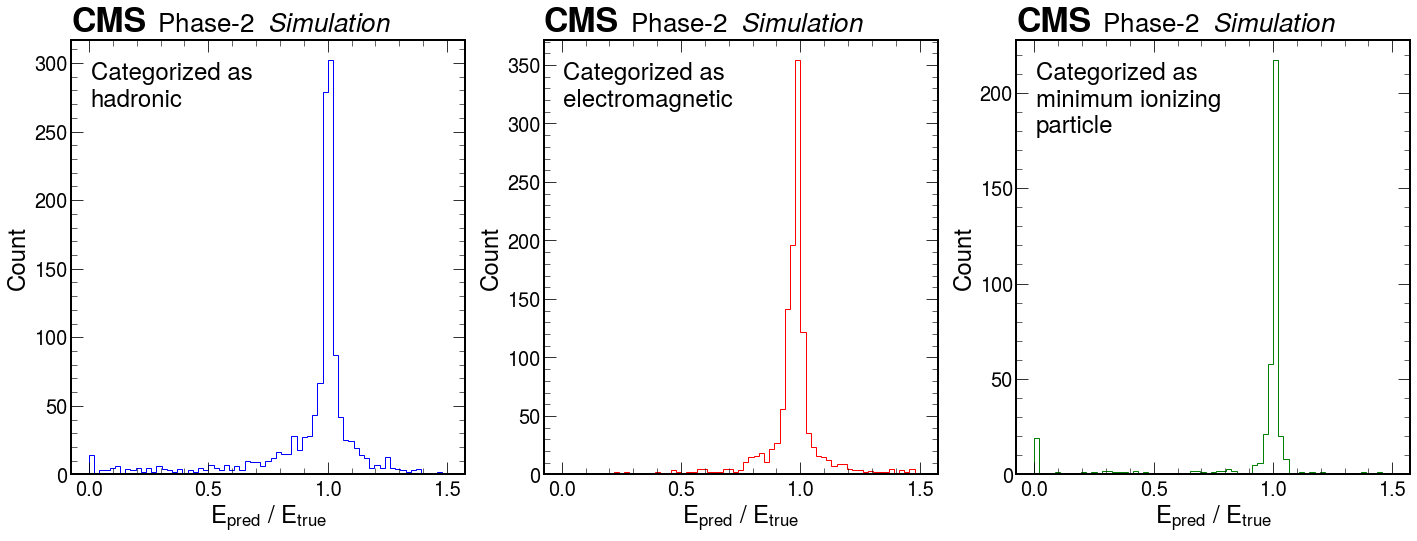

In [51]:
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

class PlotStatistics():
    
    FONTSIZE = 24
    
    def __init__(self, loader):
        self.loader = loader
        self.num_classes = 4
        self.n_events = 100
#         self.n_events = None
        
    def events(self):
        return EventFactory(self.loader, self.n_events)
                
    def single_confusion_matrix(self, event):
        conf_mat = confusion_matrix(
            event.target_nodes, event.predictions_nodes,
            labels = np.arange(self.num_classes),
            # normalize = 'true'
            )
        # If there are zero events of a category, sklearn puts a zero
        # on the diagonal. That screws up averaging.
        # for i_cat in range(self.num_classes):
        #     if conf_mat[i_cat][i_cat] == 0.0:
        #         conf_mat[i_cat][i_cat] = 1.0
        return conf_mat
    
    def average_confusion_matrix(self):
        total_confusion_matrix = np.zeros((self.num_classes, self.num_classes))
        for event in self.events():
            total_confusion_matrix = np.add(
                total_confusion_matrix,
                self.single_confusion_matrix(event)
                )
        sums = total_confusion_matrix.sum(axis=0)
        return total_confusion_matrix / sums
    
    def _energy_collection_perevent(self, event, i_cat):
        pred_energy = event.X[event.predictions_nodes == i_cat][:,4].sum()
        true_energy = event.X[event.target_nodes == i_cat][:,4].sum()
        return pred_energy/true_energy if true_energy > 0. else -1
    
    def get_energy_collection(self):
        energy_collection_per_cat = [ [] for i_cat in range(self.num_classes) ]
        for event in self.events():
            for i_cat in range(self.num_classes):
                energy_collection = self._energy_collection_perevent(event, i_cat)
                if energy_collection != -1:
                    energy_collection_per_cat[i_cat].append(energy_collection)
        return energy_collection_per_cat

    def plot_energy_collection_hist(self, energy_collection_per_cat=None, savefig=None):
        fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(24,8))
        color_cycler = cycler.cycler(color=['b', 'r', 'g', 'y', 'm', 'c'])()
        labels = [ 'Hadronic', 'EM', 'MIP' ]
        longlabels = [ 'hadronic', 'electromagnetic', 'minimum ionizing\nparticle' ]
        
        if energy_collection_per_cat is None:
            energy_collection_per_cat = self.get_energy_collection()

        for i_cat, ax in zip(range(1, self.num_classes), axs.ravel()):
            ax.hist(
                energy_collection_per_cat[i_cat],
                bins = np.linspace(0.0, 1.5, 70),
                histtype = u'step', label = labels[i_cat-1],
                **next(color_cycler)
                )
#             ax.legend(fontsize=self.FONTSIZE)
            ax.set_ylabel('Count', fontsize=self.FONTSIZE)
            ax.set_xlabel('$E_{pred}$ / $E_{true}$', fontsize=self.FONTSIZE)
            ax.tick_params(axis='both', which='major', labelsize=20)
            hep.label._exp_text('CMS', text=' Phase-2  $\it{Simulation}$', italic=(False, False), ax=ax)
            
            ax.text(
                0.05, 0.95,
                'Categorized as\n' + longlabels[i_cat-1],
                transform=ax.transAxes, verticalalignment='top',
                fontsize=24
                )

        # fig.subplots_adjust(left=0, bottom=0, right=1.2, top=1)
        # fig.tight_layout(rect=[0,0,.8,1]) 
        # fig.tight_layout(pad=40)
        
        if savefig: fig.savefig(savefig, bbox_inches='tight')

plot = PlotStatistics(valid_loader)
plot.plot_energy_collection_hist(
    energy_collection_per_cat,
    savefig='energycollection.pdf'
    )

In [58]:
conf_mat = plot.average_confusion_matrix()

In [59]:
conf_mat

array([[9.96277491e-01, 1.71183323e-02, 1.23731750e-02, 1.34378499e-02],
       [9.08405214e-04, 9.06437768e-01, 9.30237790e-02, 4.59126540e-02],
       [2.81204849e-03, 7.51195586e-02, 8.94603046e-01, 1.79171333e-02],
       [2.05521542e-06, 1.32434090e-03, 0.00000000e+00, 9.22732363e-01]])

In [7]:
# plot.n_events = 100
plot.n_events = None
energy_collection_per_cat = plot.get_energy_collection()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


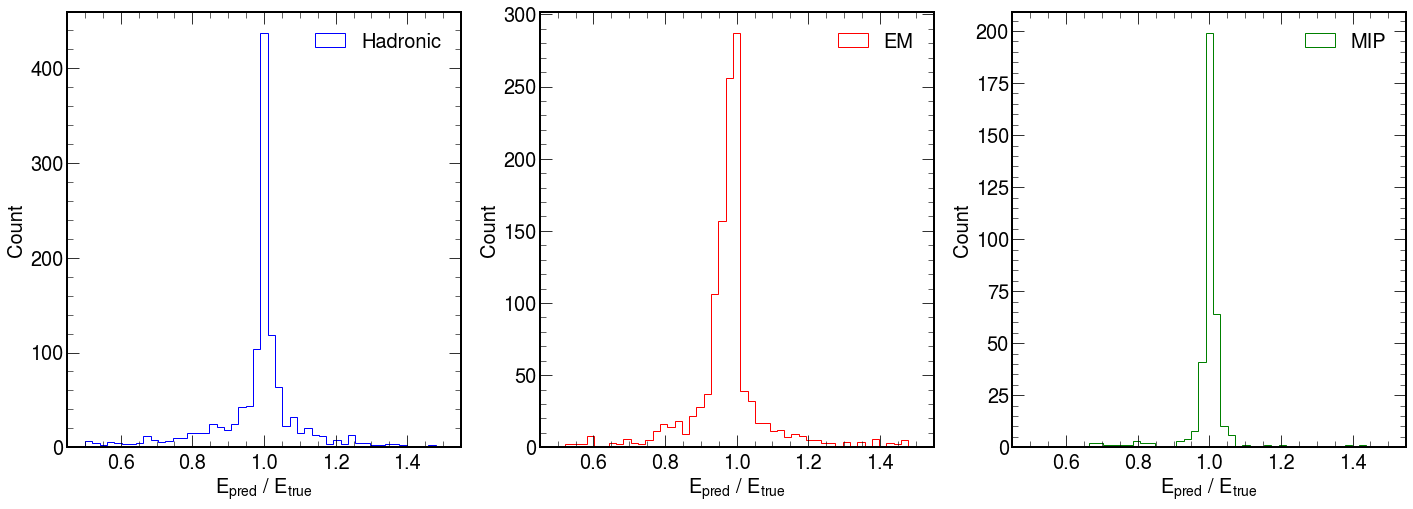

In [8]:
plot.plot_energy_collection_hist(energy_collection_per_cat, savefig='energycollection.pdf')

In [59]:


len(valid_loader.dataset)

2000

# Run stats

In [1]:
run1 = {
    'epoch': [
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
        ],
    'lr': [
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.002, 0.002, 0.002, 0.002
        ],
    'train_time': [
        6324.177651166916, 4253.762487649918, 4218.124219417572, 4221.684273719788, 4183.307936906815, 4134.225873947144, 4061.6644065380096, 4047.90536570549, 4061.4135117530823, 4183.588454723358, 4131.583730697632, 4088.7306637763977, 4093.697160959244, 4085.569967508316, 4125.02201962471
        ],
    'train_loss': [
        0.10377288740255608, 0.057448003104209416, 0.03804767565054135, 0.030795274627362233, 0.02854671766355068, 0.027766726381344142, 0.0266493256749834, 0.025907407293525465, 0.02524809802173536, 0.02536988424669403, 0.02481759059849992, 0.021999413916200295, 0.021448805694961378, 0.021116232348740736, 0.0208053860092015
        ],
     'valid_time': [
        410.6458647251129, 309.39966893196106, 312.68042373657227, 317.21641731262207, 309.434232711792, 307.60900807380676, 299.0926079750061, 309.525661945343, 296.1599464416504, 300.8047549724579, 298.83772563934326, 286.12596893310547, 299.20038771629333, 295.50660276412964, 297.86000752449036
        ],
     'valid_loss': [
        0.07089184696495067, 0.05946131413634066, 0.045129214793045776, 0.046677020349552546, 0.04286726180333858, 0.04810577621738054, 0.05487118978139779, 0.0587094611109701, 0.04716922001552939, 0.044802185981838646, 0.043591331966815916, 0.04169359848304316, 0.04218300868499455, 0.04274640398865995, 0.04325389367103889
        ],
     'valid_acc': [
        0.9741369388711315, 0.9783958444232737, 0.9844605355593323, 0.9842700274894178, 0.9857962292765973, 0.9842040682156951, 0.9840435304675466, 0.9814934245728191, 0.9831963284292307, 0.9843320316633011, 0.984448694825651, 0.9853877730962661, 0.9852732225959423, 0.9850609737598287, 0.9845620170340992
        ]
    }

run2 = {
    'epoch': [
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
        ],
    'lr': [
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01
        ],
    'train_time': [
        6393.711959600449, 4178.148412466049, 4157.117978096008, 4157.211435079575, 4125.193572998047, 4118.75168967247, 4127.9372181892395, 4121.673336267471, 4117.5985786914825, 4105.28152012825, 4115.9033353328705, 4131.489298343658, 4111.980840206146, 4104.899773836136, 4055.4143097400665
        ],
    'train_loss': [
        0.023781591811145406, 0.023839383520685545, 0.023557746249838373, 0.02358903770503332, 0.023331180006561567, 0.023001115460672565, 0.022996737414070198, 0.022878607296433415, 0.022649724025650925, 0.022540978932822496, 0.021988861416050724, 0.02180476271676497, 0.021608998738863648, 0.02175516043216362, 0.021404460783450503
        ],
    'valid_time': [
        392.2057523727417, 304.6115503311157, 304.1537148952484, 267.91484928131104, 299.1613919734955, 301.03170013427734, 315.80564403533936, 296.16405749320984, 299.8784658908844, 298.3083529472351, 306.57769656181335, 296.79882192611694, 295.6033601760864, 289.10363030433655, 284.42072653770447
        ],
    'valid_loss': [
        0.041763428910575384, 0.04193023364092005, 0.04622436405170447, 0.042746262200575987, 0.049297176471794955, 0.04292126015310714, 0.04071941465521013, 0.03885517228545359, 0.04151313309676243, 0.04711069894037064, 0.03998220038605632, 0.0434412999295555, 0.03813596879226088, 0.039399069138396615, 0.038342497432137405
        ],
    'valid_acc': [
        0.9835484551441441, 0.9847653484711955, 0.983592206900755, 0.9836144881153794, 0.9824468247267044, 0.9842502765560572, 0.9853446846172681, 0.9850497226062477, 0.984614145741302, 0.9831287723760694, 0.9837094105115303, 0.9829146319704674, 0.9862315113514928, 0.9853260145807581, 0.9853664745151423
        ]
    }

run3 = {
    'epoch': [
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
        ],
    'lr': [
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 4e-05, 4e-05
        ],
    'train_time': [
        6579.7062702178955, 4121.941504478455, 4052.8352406024933, 4053.7479207515717, 4111.890422344208, 4219.363276958466, 4201.746541023254, 4158.108087301254, 4161.344284534454, 4121.543572187424, 4130.514667272568, 4112.220765113831, 4131.285081863403, 4149.606661319733, 4146.7831518650055
        ],
    'train_loss': [
        0.01942829377591437, 0.0186074296199682, 0.018151123122650718, 0.0177781273633979, 0.01747247215665894, 0.01718860979458711, 0.01693912215463733, 0.01669192689661479, 0.01655355881554115, 0.016465987390262598, 0.016394486810130005, 0.01632587990100106, 0.016262892289672877, 0.01623054000479396, 0.016189497770941797
        ],
    'valid_time': [
        368.45184206962585, 295.69405150413513, 294.82334327697754, 295.6670708656311, 310.4765841960907, 304.4638922214508, 298.02760124206543, 293.3672151565552, 298.9092390537262, 290.416663646698, 297.1592609882355, 305.22506046295166, 292.5322005748749, 293.6967179775238, 307.029248714447
        ],
    'valid_loss': [
        0.03701958781151552, 0.03710386449380894, 0.038417042425462566, 0.03940062614059843, 0.04022842611254419, 0.041361153355147506, 0.04218753294138514, 0.039963547263607554, 0.04032462160935256, 0.04062007844858772, 0.041095737234394164, 0.041352529618501194, 0.04165194633220199, 0.04121568229288278, 0.04120165970875905
        ],
    'valid_acc': [
        0.9862051767736787, 0.9861718409321734, 0.985806989113428, 0.9856540913407462, 0.9855609622507339, 0.9853078604268358, 0.9850573625817143, 0.9857811212865266, 0.9857374186615908, 0.9856956321719809, 0.9855818677784575, 0.9855304023488675, 0.9854670961855961, 0.9855438398619871, 0.9855580389160697
        ]
    }

In [9]:
runs = {key : run1[key] + run2[key] + run3[key] for key in run1.keys()}
runs['epoch'] = list(range(len(runs['epoch'])))
runs

{'epoch': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44],
 'lr': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.002,
  0.002,
  0.002,
  0.002,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0002,
  0.0002,
  0.0002,
  0.0002,
  0.0002,
  0.0002,
  4e-05,
  4e-05],
 'train_time': [6324.177651166916,
  4253.762487649918,
  4218.124219417572,
  4221.684273719788,
  4183.307936906815,
  4134.225873947144,
  4061.6644065380096,
  4047.90536570549,
  4061.4135117530823,
  4183.588454723358,
  4131.583730697632,
  4088.7306637763977,
  4093.697160959244,
  4085.569967508316,
  4125.02201962471,
  6393.7

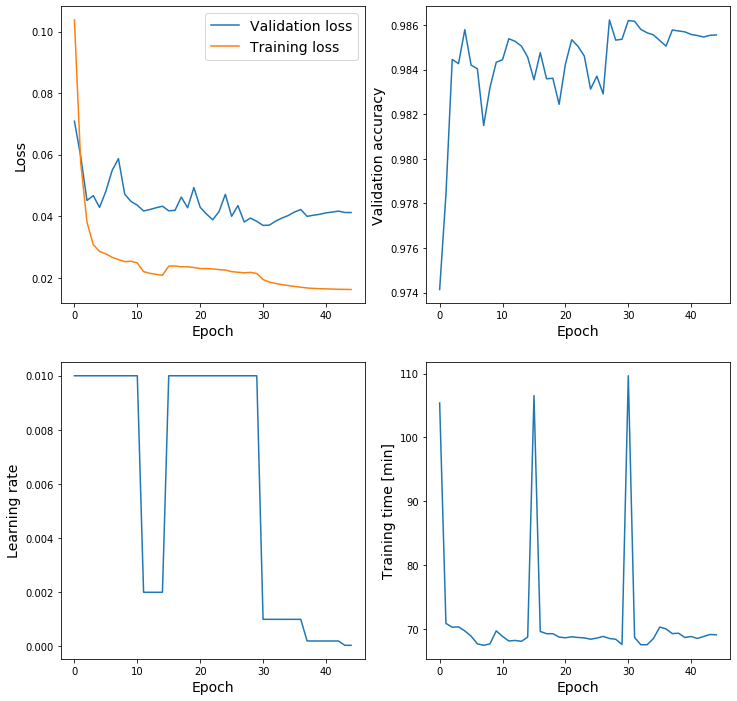

In [24]:
def plot_valid_loss():
    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    
    axs[0,0].plot(runs['epoch'], runs['valid_loss'], label='Validation loss')
    axs[0,0].plot(runs['epoch'], runs['train_loss'], label='Training loss')
    axs[0,0].set_xlabel('Epoch', fontsize=14)
    axs[0,0].set_ylabel('Loss', fontsize=14)
    axs[0,0].legend(fontsize=14)

    axs[0,1].plot(runs['epoch'], runs['valid_acc'])
    axs[0,1].set_xlabel('Epoch', fontsize=14)
    axs[0,1].set_ylabel('Validation accuracy', fontsize=14)

    axs[1,0].plot(runs['epoch'], runs['lr'])
    axs[1,0].set_xlabel('Epoch', fontsize=14)
    axs[1,0].set_ylabel('Learning rate', fontsize=14)

    axs[1,1].plot(runs['epoch'], np.array(runs['train_time']) / 60.)
    axs[1,1].set_xlabel('Epoch', fontsize=14)
    axs[1,1].set_ylabel('Training time [min]', fontsize=14)

    

plot_valid_loss()

In [54]:
conf = np.array([[9.98365305e-01, 2.67563432e-02, 2.75065662e-02, 1.63573957e-02],
       [8.55842280e-04, 8.00371637e-01, 1.48721943e-01, 6.79502306e-02],
       [7.20119774e-04, 1.71500373e-01, 8.23290239e-01, 8.90271372e-03],
       [5.87332643e-05, 1.37164677e-03, 4.81252115e-04, 9.06789660e-01]])

labels = ['Noise', 'HAD', 'EM', 'MIP']
print(' '*9, end='')
for l in labels:
    print('{:6s}'.format(l), end='   ')
print()

for i, row in enumerate(conf):
    print('{:6s}'.format(labels[i]), end='   ')
    for e in row:
        print('{0:.4f}'.format(e), end='   ')
    print()


         Noise    HAD      EM       MIP      
Noise    0.9984   0.0268   0.0275   0.0164   
HAD      0.0009   0.8004   0.1487   0.0680   
EM       0.0007   0.1715   0.8233   0.0089   
MIP      0.0001   0.0014   0.0005   0.9068   
